# Installing Modules

In [ ]:
%%capture
!pip install -qq pytorch_lightning tableprint spacy==3
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

# Imports

In [ ]:
# Import Libraries
import numpy as np
import math
import matplotlib.pyplot  as plt
import spacy
import pandas as pd
import os

# PyTorch related
import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# My Custom Code
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import tableprint as tp

In [ ]:
# Manual Seed
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Language Definitions

In [ ]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

# Tokenizers

In [ ]:
token_transform[SRC_LANGUAGE]  = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# Yield Function

In [ ]:
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Special Tokens

In [ ]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# Building Vocab

In [ ]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

## Setting default token

In [ ]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
print(f"Length of Source Vocabulary: {len(vocab_transform['de'])}")
print(f"Length of Targe Vocabulary: {len(vocab_transform['en'])}")

Length of Source Vocabulary: 19215
Length of Targe Vocabulary: 10838


# Collator

In [ ]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

# DataLoader

In [ ]:
BATCH_SIZE = 32
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

# Model

## Boilerplate Code

In [ ]:
class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.train_acc =  torch.tensor(0.)
        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        

    def training_step(self, batch, batch_idx):
        src, trg = batch 
        output = self(src, trg[:,:-1]) # get rid of EOS in target
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        loss_train = self.loss(output, trg)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        src, trg = batch  
        output = self(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        loss_valid = self.loss(output, trg) 
        return {"loss": loss_valid}
    
    def training_epoch_end(self, outputs):
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
    
    def validation_epoch_end(self, outputs):
        if trainer.sanity_checking:
          print('sanity check')
          return
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train PPL': math.exp(self.avg_train_loss), 'Train Loss': self.avg_train_loss,  'Valid PPL': math.exp(avg_valid_loss), 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
          self.table_context = tp.TableContext(headers=['epoch', 'Train PPL', 'Train Loss', 'Valid PPL', 'Valid Loss'])
          self.table_context.__enter__()
        self.table_context([self.current_epoch+1, math.exp(self.avg_train_loss.item()), self.avg_train_loss.item(), math.exp(avg_valid_loss.item()), avg_valid_loss.item()])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
          self.validation_end(outputs)
    
    def validation_end(self, outputs):
        self.table_context.__exit__()

## Self-Attention

In [ ]:
class SelfAttention(pl.LightningModule):
    def __init__(self, embed_size, heads):
        '''
        embed_size: the size of the embedding (or embedding dimension)
        heads: the number of heads that our embedding is split into for a 
                narrow self-attention implementation 
        '''
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert embed_size % heads == 0, 'embed_size must be an integer multiple of number of heads!'
        # or
        assert (self.head_dim * heads == embed_size), 'embed_size needs to be divisible by heads'

        self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)

        # After concatenating
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value, mask):
        N = query.shape[0] # batch size (or number of samples)
        query_len, key_len, value_len  = query.shape[1], key.shape[1], value.shape[1]  # length of sequence; all are same!

        # split query,key, and value into self.heads pieces
        query = query.reshape(N, query_len, self.heads, self.head_dim)
        key = key.reshape(N, key_len, self.heads, self.head_dim)
        value = value.reshape(N, value_len, self.heads, self.head_dim)

        queries = self.queries(query)  # (N, query_len, heads, heads_dim)
        keys = self.keys(key)  # (N, key_len, heads, head_dim)
        values = self.values(value)  # (N, value_len, heads, head_dim)


        # query shape: (N, query_len, heads, head_dim) 
        # key shape: (N, key_len, heads, head_dim) 
        # energy shape: (N, heads, query_len, key_len) 
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3) 
        
        # attention shape: (N, heads, query_len, key_len) 
        # value shape: (N, value_len, heads, head_dim) 
        # out shape: (N, query_len, heads, head_dim) ; then flatten the last two dimensions
        # Note that the second argument in the following must be nvhd, but since
        # key_len = value_len, k=v
        out = torch.einsum('nhqk,nkhd->nqhd', [attention, values]).reshape(N, query_len, self.heads*self.head_dim)

        out = self.fc_out(out)

        return out

## Transformer Block

In [ ]:
class TransformerBlock(pl.LightningModule):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
                                    nn.Linear(embed_size, forward_expansion * embed_size),
                                    nn.ReLU(),
                                    nn.Linear(forward_expansion * embed_size, embed_size)
                                    )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask):
        attention = self.attention(query, key, value, mask)

        x = self.dropout(self.norm1(attention + query))

        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x)) 

        return out


## Encoder

In [ ]:
class Encoder(pl.LightningModule):
    def __init__(self, 
                        src_vocab_size,
                        embed_size,
                        num_layers,
                        heads,
                        device,
                        forward_expansion,
                        dropout,
                        max_length):
        super(Encoder, self).__init__()

        self.embed_size = embed_size
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
             TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out


## Decoder Block

In [ ]:
class DecoderBlock(pl.LightningModule):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)

        self.transformerblock = TransformerBlock(embed_size, heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key_enc, value_enc, src_mask, trg_mask):
        '''
        note that query = query_dec = key_decoder = value_dec
        note that key_enc = value_enc 
        src_mask is optional; only for preventing computation over padded sequences
        trg_mask is compulsory; needed for masked self-attention
        '''
        attention = self.attention(query, query, query, trg_mask)

        query_tb = self.dropout(self.norm(attention + query))

        out = self.transformerblock(query_tb, key_enc, value_enc, src_mask)

        return out



## Decoder

In [ ]:
class Decoder(pl.LightningModule):
    def __init__(self, 
                        trg_vocab_size,
                        embed_size,
                        num_layers,
                        heads,
                        device,
                        forward_expansion,
                        dropout,
                        max_length):
        super(Decoder, self).__init__()
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
             DecoderBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        for layer in self.layers:
            out = layer(out, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(out)
        return out

## Transformer Class/Model

In [ ]:
class Transformer(TL):
    def __init__(self,
                    src_vocab_size,
                    trg_vocab_size,
                    src_pad_idx,
                    trg_pad_idx,
                    embed_size = 512,
                    num_layers = 6,
                    forward_expansion = 4,
                    heads = 8,
                    dropout = 0,
                    device = device,
                    max_length = 100
                    ):
        super(Transformer, self).__init__()

        self.loss = nn.CrossEntropyLoss(ignore_index=src_pad_idx)
        self.lr = 1e-3

        self.encoder = Encoder(src_vocab_size,
                                embed_size,
                                num_layers,
                                heads,
                                device,
                                forward_expansion,
                                dropout,
                                max_length)
        self.decoder = Decoder(trg_vocab_size,
                                embed_size,
                                num_layers,
                                heads,
                                device,
                                forward_expansion,
                                dropout,
                                max_length)
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

    def make_src_mask(self, src):
        # (N, seq_len) -> (N,1,1,seq_len)
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) # for einsum method
        return src_mask.to(self.device)
    
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )

        return trg_mask.to(self.device)


    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_out, src_mask, trg_mask)
        return out
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

In [ ]:
src_pad_idx = 1
trg_pad_idx = 1
src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
trg_vocab_size = len(vocab_transform[TGT_LANGUAGE])
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(
    device
)


# Training

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content',
    filename='sst-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [ ]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2_Assign_12', version=0)
trainer = pl.Trainer(max_epochs=20, num_sanity_val_steps=1, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback], gradient_clip_val=1, gradient_clip_algorithm='norm')
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
checkpoint_callback.best_model_path

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 24.1 M
2 | decoder | Decoder          | 27.1 M
---------------------------------------------
51.2 M    Trainable params
0         Non-trainable params
51.2 M    Total params
204.903   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  "Your `IterableDataset` has `__len__` defined."


sanity check


╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train PPL │  Train Loss │   Valid PPL │  Valid Loss │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │           1 │           0 │      51.884 │       3.949 │


│           2 │      66.982 │      4.2044 │      43.356 │      3.7695 │


│           3 │      45.074 │      3.8083 │      41.621 │      3.7286 │


│           4 │      31.738 │      3.4575 │      41.741 │      3.7315 │


│           5 │       24.72 │      3.2076 │      41.005 │      3.7137 │


│           6 │       20.51 │      3.0209 │      41.134 │      3.7168 │


│           7 │      19.009 │      2.9449 │      42.293 │      3.7446 │


│           8 │      17.376 │      2.8551 │      45.076 │      3.8084 │


│           9 │      16.257 │      2.7885 │      45.699 │      3.8221 │


│          10 │       13.53 │      2.6049 │      48.047 │      3.8722 │


│          11 │      12.221 │      2.5031 │      51.052 │      3.9328 │


│          12 │      9.7185 │       2.274 │      54.112 │      3.9911 │


│          13 │      9.0562 │      2.2035 │      60.001 │      4.0944 │


│          14 │      7.8073 │      2.0551 │       66.37 │      4.1953 │


│          15 │      7.4772 │      2.0119 │      71.493 │      4.2696 │


│          16 │      6.6162 │      1.8895 │      73.569 │      4.2982 │


│          17 │      6.0276 │      1.7964 │      82.139 │      4.4084 │


│          18 │      5.1714 │      1.6431 │      88.241 │      4.4801 │


│          19 │      4.5196 │      1.5084 │       102.8 │      4.6328 │


│          20 │      4.2671 │      1.4509 │      108.76 │      4.6891 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

# Training Log

In [ ]:
root='./csv_logs/' + 'END2_Assign_12' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

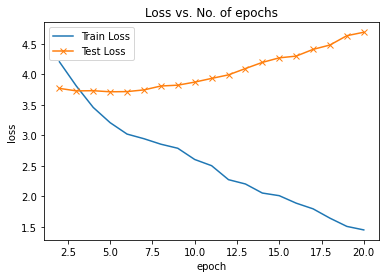

In [ ]:
plt.plot(metrics['epoch'][1:], metrics['Train Loss'][1:], label="Train Loss")
plt.plot(metrics['epoch'][1:], metrics['Valid Loss'][1:], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

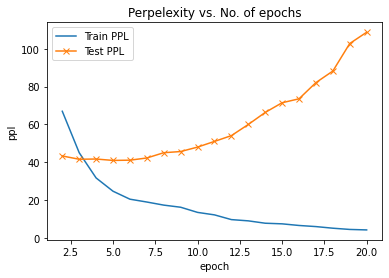

In [ ]:
plt.plot(metrics['epoch'][1:], metrics['Train PPL'][1:], label="Train PPL")
plt.plot(metrics['epoch'][1:], metrics['Valid PPL'][1:], '-x', label="Test PPL")
plt.xlabel('epoch')
plt.ylabel('ppl')
plt.legend()
plt.title('Perpelexity vs. No. of epochs');

# Inference on Random Samples from Test Data

In [ ]:
%%capture
model.to(device)
model.eval()

In [ ]:
for i in np.random.randint(0,32, 5):
  src_sent_i = next(iter(test_loader))[0][i,:]
  trg_sent_i = next(iter(test_loader))[1][i,:]
  stop_ind_src = (src_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
  stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
  src_sent_tok = [vocab_transform['de'].lookup_token(word_i) for word_i in src_sent_i[:stop_ind_src]]
  trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[:stop_ind_trg]]
  src_sent = " ".join(src_sent_tok[1:]) # skip the initial <bos> token
  trg_sent = " ".join(trg_sent_tok[1:]) # skip the initial <bos> token
  src_sent_tensor = src_sent_i.clone().detach().unsqueeze(0).to(device)   
  trg_sent_tensor = trg_sent_i.clone().detach().unsqueeze(0).to(device) 
  with torch.no_grad():
        output = model(src_sent_tensor, trg_sent_tensor)
        out = output.squeeze(0)
        out = torch.argmax(out,dim=1)
        if any(out==3) == False: # if <eos> token is not found
            stop_ind_pred = len(out)   # use complete sentence
        else:
            stop_ind_pred = (out==3).nonzero()[0].item() # stop when <eos> token is found
        pred_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in out]
        pred_sent = " ".join(pred_sent_tok[:stop_ind_pred])
        start = "\033[1m"
        end = "\033[0;0m"
        print(f'{start}Source Sentence: {end}{src_sent}')
        print(f'{start}Target Sentence: {end}{trg_sent}')
        print(f'{start}Translated Sentence: {end}{pred_sent}')
        print()

Source Sentence: Eine Blondine hält mit einem Mann im Sand Händchen .
Target Sentence: A blond holding hands with a guy in the sand .
Translated Sentence: A man woman a and a chair in a kitchen .

Source Sentence: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit <unk> im Hintergrund .
Target Sentence: Five people wearing winter jackets and helmets stand in the snow , with <unk> in the background .
Translated Sentence: A men are white vests are safety are in front back . as a in the background .

Source Sentence: Ein Mädchen in einem Karateanzug bricht einen Stock mit einem Tritt .
Target Sentence: A girl in karate uniform breaking a stick with a front kick .
Translated Sentence: A man in a clothes is a brochure . a boy of .

Source Sentence: Zwei Männer tun so als seien sie Statuen , während Frauen ihnen zusehen .
Target Sentence: Two men pretend to be <unk> while women look on .
Translated Sentence: A men are on a fun . a in at .

Source Sentence: Eine Frau , die in eine